In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [2]:
# helper functions
def svm_contour(x, w, c):
    # c = 0 for decision boundry, +1, -1 for support
    # x*w[0] +  unknown * w[1] + 1*w[2] = c
    x_plot = (c-x*w[0]-w[2])/w[1]
    return x_plot

def plot_svm(w_k, plot_bounds):
    plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
    db = [svm_contour(plot_bounds[0], w_k, 0), svm_contour(plot_bounds[1], w_k, 0)] 
    db_pos1 = [svm_contour(plot_bounds[0], w_k, 1.), svm_contour(plot_bounds[1], w_k, 1.)] 
    db_neg1 = [svm_contour(plot_bounds[0], w_k, -1.), svm_contour(plot_bounds[1], w_k, -1.)] 
    plt.plot(plot_bounds,db, color="green", label="decision boundary")
    plt.plot(plot_bounds,db_pos1, color="green", linestyle="--", label="support vector")
    plt.plot(plot_bounds,db_neg1, color="green", linestyle="--")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

def plot_ls_results(b_classes, b_hat, title, label, cutoffs):
    fig,ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
    c = 0
    ax.scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
    ax.plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
    ax.scatter(range(len(b_classes[:,c])), b_hat[:,c], label=label, color="C2", s=15)
    ax.plot(range(len(b_classes[:,c])), b_hat[:,c], alpha=0.5, color="C2")
    for cutoff in cutoffs:
        ax.plot([0,len(b_classes[:,c])], [cutoff, cutoff], alpha=0.5, linestyle="--", color="k", label="{} cutoff".format(cutoff))
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0)) # legend
    plt.title(title, fontsize=20) # title
    fig.tight_layout() # prevent overlapping

def plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title):
    fig,ax = plt.subplots(len(classes),1)
    plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
    
    for c in classes:
        ax[c].set_title("Class {} vs. Rest".format(c),fontsize=15)
        ax[c].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_svm[:,c], label="svm estimate", color="C1", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_svm[:,c], alpha=0.5, color="C1")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_ls[:,c], label="ls estimate", color="C2", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_ls[:,c], alpha=0.5, color="C2")
        ax[c].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="decision boundary")
        ax[0].legend(bbox_to_anchor=(0.8, 1.3), loc='right', ncol=1,fontsize=12) # legend
    title = fig.suptitle(title, fontsize=20) # title
    fig.tight_layout() # prevent overlapping
    
def printTable(header, data):
    """
    Prints table with columns of header and data.

    Parameters
    ----------
    header : []
        list of header labels
        ex. header = ["one","two","three"]
    data : [[],[],...,[]]
        list of lists, each inner list is a data line
        data line must index with header appropriately
        ex. data = [[1, 2, 3],[1, 2, 3]]
    """

    # print headers
    col_widths=[]
    for i,label in enumerate(header):
        col_widths.append(len(label))
        if i == 0 :
            print("| ",end="")
        print(str(label).center(len(label)), end=" | ")
    print()

    # print separating line
    for i,width in enumerate(col_widths):
        if i == 0 :
            print("| ",end="")
        print("".center(width,"-"), end=" | ")
    print()

    # print data
    for i,line in enumerate(data):
        for i,value in enumerate(line):
            if i == 0 :
                print("| ",end="")
            print(str(value).center(col_widths[i]), end=" | ")
        print()

## Toy Data

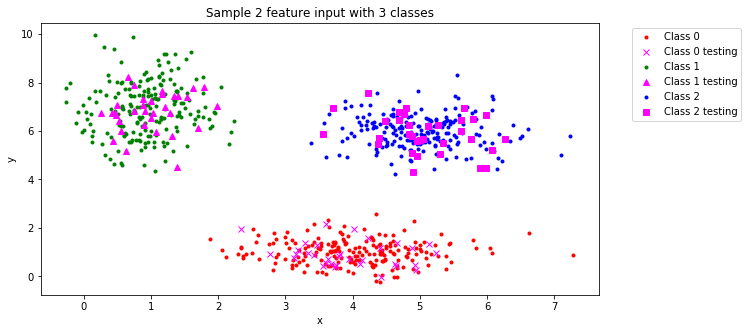

In [3]:
colors = ['r', 'g', 'b']
samplePerClass  = 33
styles  = ['x','^','s']

# Define three cluster centers
centers = [[4, 1],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.5],
          [0.5, 1.1],
          [0.7, 0.7]]

noise_multiplier = 1

# seeded for reproducibility
np.random.seed(2)  

# Initial varables
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
x_testing = np.zeros(1)
y_testing = np.zeros(1)
known_labels_testing = np.zeros(1)

# Zip object is an iterator of tuples, enumerate returns centers: sigmas pair
# Total of 200 sample points, in 3 clusters
for i, ((x_center, y_center), (x_sigma, y_sigma)) in enumerate(zip(centers, sigmas)):
    # Create row array x or y value of each point
    xpts = np.hstack((xpts, np.random.standard_normal(200) * x_sigma + x_center))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * y_sigma + y_center))
    labels = np.hstack((labels, np.ones(200) * i))
    x_testing = np.hstack((x_testing, np.random.standard_normal(samplePerClass) * x_sigma*noise_multiplier + x_center))
    y_testing = np.hstack((y_testing, np.random.standard_normal(samplePerClass) * y_sigma*noise_multiplier + y_center))
    known_labels_testing = np.hstack((known_labels_testing, np.ones(samplePerClass) * i))

# Remove the extra 0 at front 
xpts = np.delete(xpts,0)
ypts = np.delete(ypts,0)
labels = np.delete(labels,0)
x_testing = np.delete(x_testing,0)
y_testing = np.delete(y_testing,0)
known_labels_testing = np.delete(known_labels_testing,0)

# format feature data sets
xy = np.vstack((xpts,ypts)).T
xy_testing = np.vstack((x_testing,y_testing)).T
data_testing = np.hstack((np.transpose(np.vstack((x_testing,y_testing))), np.ones((samplePerClass*3, 1))))

# Visualize data
for j in range(3):
    plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
    plt.plot(xpts[j == labels],ypts[j==labels],'.', color = colors[j], label = 'Class %s'%j)
    plt.plot(x_testing[j == known_labels_testing],y_testing[j==known_labels_testing],styles[j], color = 'fuchsia', label = 'Class %s testing'%j)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample 2 feature input with 3 classes')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.show()

## Least Squares

### Train

In [4]:
# get data
X = xy
b = labels.transpose().reshape(len(labels),1)

# calculate weights
w_ls = np.linalg.inv(X.T@X)@X.T@b

print("Least Squares Weights:\n", w_ls)
print()
print("Training complete!")

Least Squares Weights:
 [[0.08650129]
 [0.17743842]]

Training complete!


### Test

| class | ls error | 
| ----- | -------- | 
|   0   |  0.00 %  | 
|   1   |  9.09 %  | 
|   2   | 48.48 %  | 


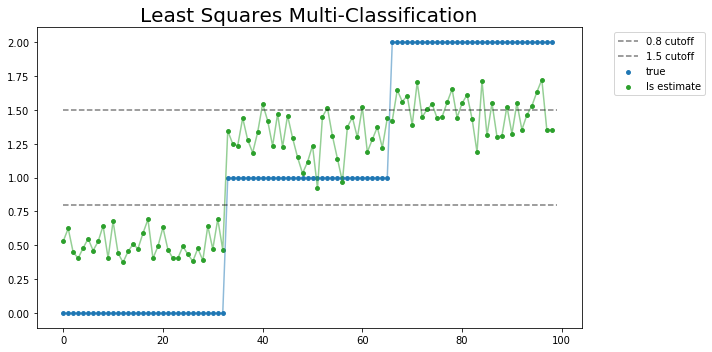

In [5]:
# get data
X_test = xy_testing
b_test = known_labels_testing

# make predictions
b_predict = X_test@w_ls

# round predictions
cutoffs = [0.8, 1.5]
classes = [0, 1, 2]

def classify(classes, b_hat, cutoffs):
    b_classified = b_hat.copy()
    for i in range(len(b_classified)):
        if b_classified[i] < cutoffs[0]:
            b_classified[i] = classes[0]
        elif b_classified[i] > cutoffs[-1]:
            b_classified[i] = classes[-1]
        else:
            loop = True
            for j in range(0, len(cutoffs)-1):
                if loop and b_classified[i] > cutoffs[j] and b_classified[i] < cutoffs[j+1]:
                    b_classified[i] = classes[j+1]
                    loop = False
        
    return b_classified

# test ls against test data
header = ["class", "ls error"]
data = []

for c in classes:
    # make classification
    b_hat = classify(classes, b_predict[np.where(b_test==c)], cutoffs).reshape(len(b_predict[np.where(b_test==c)]),)

    # find percent incorrect
    num_incorrect_svm = np.sum(b_hat != c)
    percent_incorrect_svm = num_incorrect_svm/len(b_hat)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm)])
    
# print results
printTable(header,data)

# plot
b_plot = b_test.reshape((len(b_test),1))
plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
plot_ls_results(b_plot, b_predict, "Least Squares Multi-Classification", "ls estimate", cutoffs)
plt.show()

## One vs. Rest

### Train

Class 0 converged after 6296 iterations


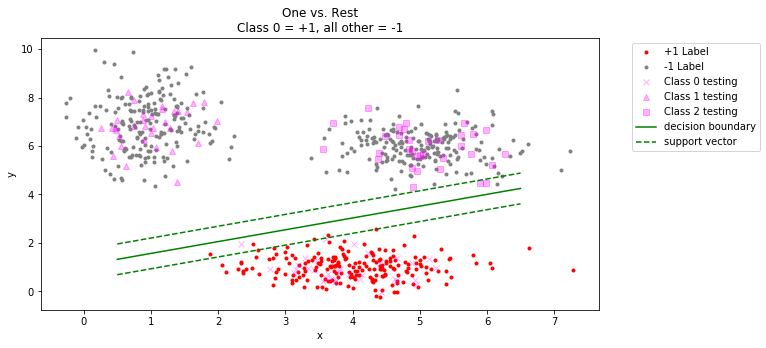

Class 1 converged after 1615 iterations


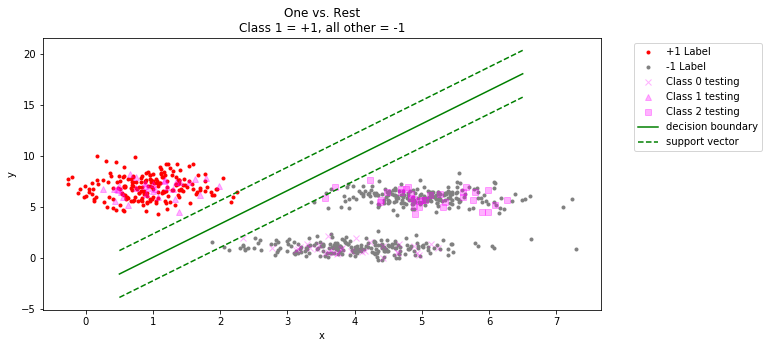

Class 2 converged after 3018 iterations


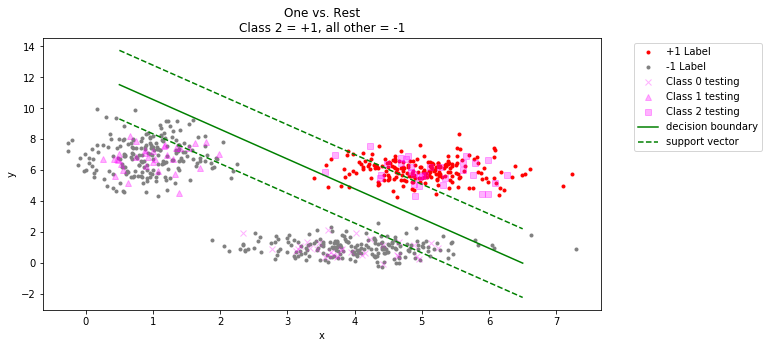

Training complete!


In [6]:
# Prep simple data in format two columns = two features = two axis
X = xy
b = labels

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
w_k = np.zeros((len(X[0])+1, 1))

r = 0.1 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2]
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))
descent_done = False

for c in classes:
    # form binary labels, assign +1 to one class, -1 to all others
    b_svm = np.where(b == c, 1, -1)
    last_loss = math.inf
    descent_done = False
    iterations = 0

    # train svm
    while not descent_done:
        loss = 0
        l_hinge = np.zeros(w_k.shape)
        # loop through training samples
        for s in range(num_samples):
            # indicator function
            if b_svm[s]*X_svm[s]@w_k < 1:
                loss += (1-b_svm[s]*X_svm[s]@w_k)
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
        # compare loss to determine if reached minimum
        if(last_loss < loss):
            print("Class {} converged after {} iterations".format(c,iterations))
            descent_done = True
        else:
            # svm weights
            w_tilda = np.copy(w_k)
            w_tilda[-1] = 0
            w_k = w_k - tau*(l_hinge+2*r*w_tilda)

        # update for next iteration
        last_loss = loss
        iterations +=1
      
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))
    
    # plot training data
    plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
    plt.plot(X[(c==b),0],X[(c==b),1],'.', color = 'r', label = '+1 Label')
    plt.plot(X[(c!=b),0],X[(c!=b),1],'.', color = 'grey', label = '-1 Label')
    # plot test data
    for j in range(3):
        plt.plot(x_testing[j == known_labels_testing],y_testing[j==known_labels_testing],styles[j], alpha=0.3, color = 'fuchsia', label = 'Class %s testing'%j)
    

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('One vs. Rest\nClass %s = +1, all other = -1'%c)

    # plot decision boundary
    plot_bounds = [0.5, 6.5]
    plot_svm(w_k, plot_bounds) # helper function 
    plt.show()

print("Training complete!")

### Test

| class | svm error | least squares error | 
| ----- | --------- | ------------------- | 
|   0   |   0.00 %  |        0.00 %       | 
|   1   |   0.00 %  |        0.00 %       | 
|   2   |   0.00 %  |        0.00 %       | 


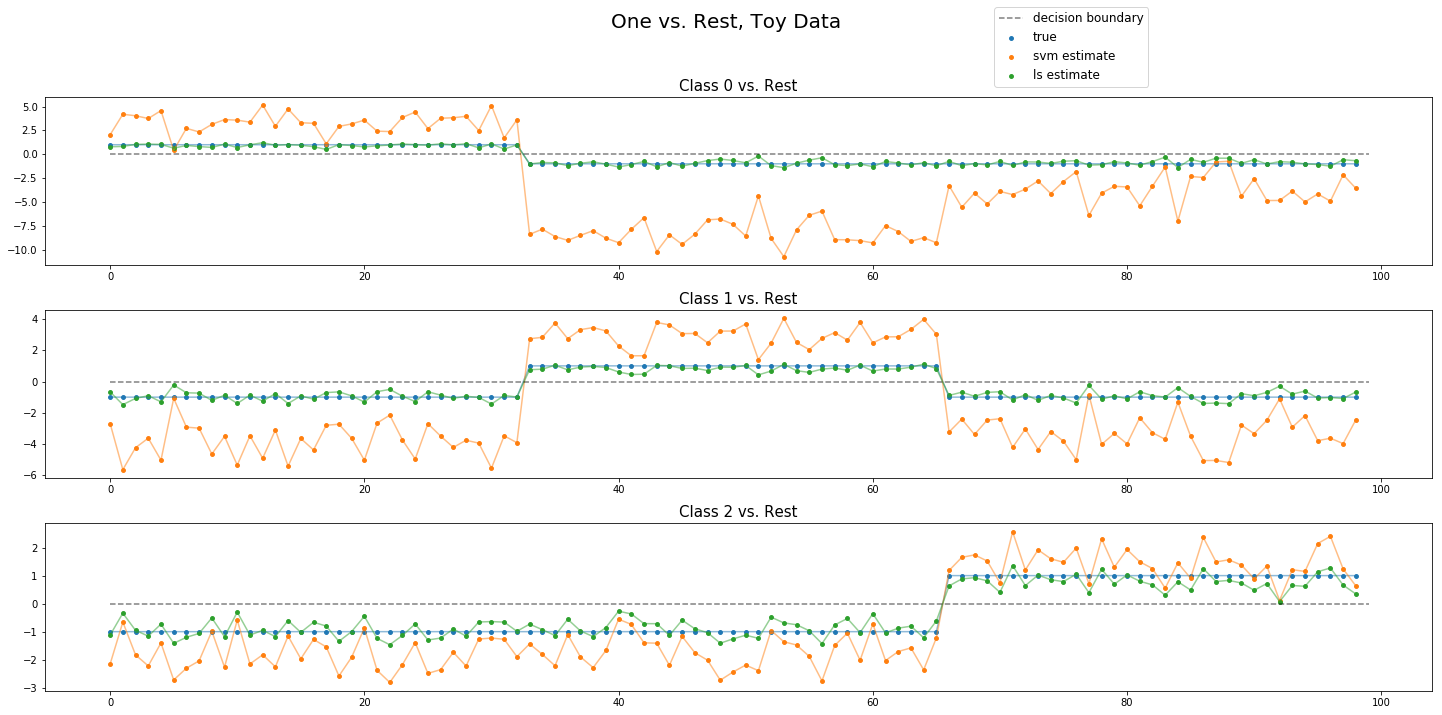

In [7]:
# test svm against test data
header = ["class", "svm error", "least squares error"]
data = []

classes = [0,1,2]
b_classes = np.zeros((len(b_test),len(classes)))
b_hat_svm = np.zeros(b_classes.shape)
b_hat_ls = np.zeros(b_classes.shape)

for c in classes:
    b_classes[:,c] = np.where(b_test == c, 1, -1)
    b_test_svm = data_testing@w_svm[:,c]
    b_test_ls = data_testing@w_ls[:,c]
    b_hat_svm[:,c] = b_test_svm.reshape(len(b_test))
    b_hat_ls[:,c] = b_test_ls.reshape(len(b_test))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_hat_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b_test)*100
    num_incorrect_svm = np.sum(np.sign(b_hat_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b_hat_svm[:,c])*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])
    
# print results
printTable(header,data)

# plot results
title = "One vs. Rest, Toy Data"
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title)
plt.show()

## One vs. One

### Train

Pair 0 vs 1 converged after 1355 iterations


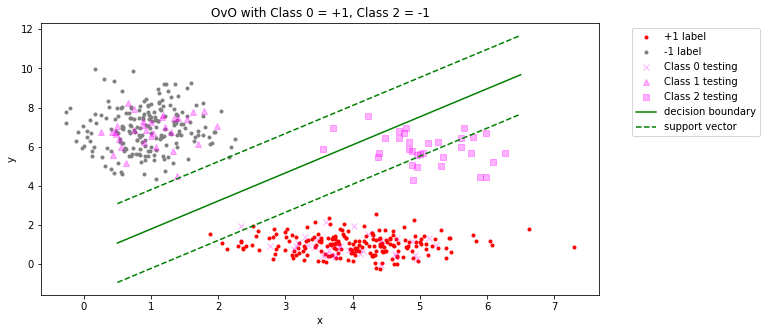

Pair 0 vs 2 converged after 5480 iterations


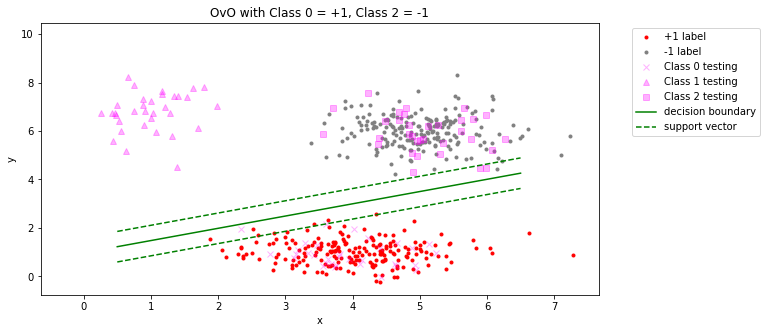

Pair 1 vs 2 converged after 1025 iterations


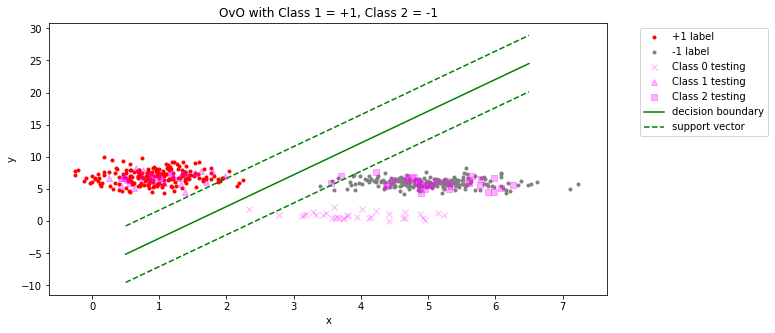

Training complete!


In [8]:
# Prep simple data in format two columns = two features = two axis
X = xy
b = labels

# model parameters
X_svm = np.hstack((X, np.ones((len(b), 1))))
w_k = np.zeros((len(X[0])+1, 1))

r = 0.1 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2]
w_svm = np.zeros((len(w_k),len(classes)))
weights_classes = []
descent_done = False

red = np.where(b == 0)
green = np.where(b == 1)
blue = np.where(b == 2)
    
for i in range(len(classes)):
    for j in range(len(classes)):
        if j>i:
            #create test groups
            g1 = np.where(b == i)[0]
            g2 = np.where(b == j)[0]

            X_class1 = [X_svm[k] for k in g1]
            X_class2 = [X_svm[k] for k in g2]
            X_class = np.vstack((X_class1,X_class2))
            b_class_orig1 = [b[k] for k in g1]
            b_class_orig2 = [b[k] for k in g2]
            b_class_orig = b_class_orig1 + b_class_orig2
            b_svm = np.where(np.asarray(b_class_orig) == i, 1, -1)

            # train svm
            last_loss = 100000000000000.
            descent_done = False
            iterations = 0

            while not descent_done:
                loss = 0
                # loop through training samples
                l_hinge = np.zeros(w_k.shape)
                for s in range(len(b_svm)):
                    # indicator function
                    if b_svm[s]*X_class[s]@w_k <= 1:
                        loss += (1-b_svm[s]*X_class[s]@w_k)
                        l_hinge = np.add(l_hinge, -b_svm[s]*X_class[s].reshape(l_hinge.shape))
    
                # compare loss to determine if reached minimum
                if(last_loss < loss):
                    print("Pair {} vs {} converged after {} iterations".format(i, j, iterations))
                    descent_done = True
                else:
                    # svm weights
                    w_tilda = np.copy(w_k)
                    w_tilda[-1] = 0
                    w_k = w_k - tau*(l_hinge+2*r*w_tilda)

                # update for next iteration
                last_loss = loss
                iterations +=1

            # save weights
            weights_classes.append(w_k.reshape(len(w_k))) # svm
            
            # Graph
            plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
            plt.plot(X[(i!=b),0],X[(i!=b),1],'.', color = 'w')
            plt.plot(X[(i==b),0],X[(i==b),1],'.', color = 'r', label = '+1 label')
            plt.plot(X[(j==b),0],X[(j==b),1],'.', color = 'grey', label = '-1 label')
            
            # plot test data
            for j in range(3):
                plt.plot(x_testing[j == known_labels_testing],y_testing[j==known_labels_testing],styles[j], alpha = 0.3, color = 'fuchsia', label = 'Class %s testing'%j)

            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('OvO with Class %s = +1, Class %d = -1'%(i,j))
            
            # plot decision boundary
            plot_bounds = [0.5, 6.5]
            plot_svm(w_k, plot_bounds) # helper function
            plt.show()
            
print("Training complete!")

### Test

In [9]:
# test svm against known training data
header = ["class", "  svm  "]
data = []
num_classes = len(classes)
count_class = np.zeros((num_classes))
count_total = np.zeros((num_classes))
b_test_svm = []

c1 = 0
c2 = 1
num_wrong = 0
counter = 0
a = 0
for x in data_testing: 
    count_class = [0]*num_classes
    counter +=1
    for w in range(len(weights_classes)):
        b_hat_svm = x@weights_classes[w]
        
        if b_hat_svm > 0:
            count_class[c1] = count_class[c1] + 1
        elif b_hat_svm < 0:
            count_class[c2] = count_class[c2] + 1
        if c2<len(classes) - 1:
            c2 = c2 + 1
        else:
            c1 = c1 + 1
            c2 = c1 + 1

    c1 = 0
    c2 = 1
    b_test_svm.append(classes[np.argmax(count_class)])
    count_total = count_total + count_class

count_wrong = np.zeros((num_classes))
count_total = np.zeros((num_classes))
error_total = np.zeros((num_classes))
for m in range(len(b_test)):
    if b_test[m] != b_test_svm[m]:
        count_wrong[int(b_test[m])] += 1
        num_wrong = num_wrong+1
    count_total[int(b_test[m])] =  count_total[int(b_test[m])] + 1
    
# find percent incorrect
percent_incorrect_svm = num_wrong/len(b_test)*100

# print out
header = [" class ", "% error"]
error_total = np.divide(count_wrong,count_total)
for c in classes:
    data.append([c, "{:0.2f} %".format(error_total[c]*100)])
data.append(["Avg","{:0.2f} %".format(percent_incorrect_svm)])
printTable(header,data)

|  class  | % error | 
| ------- | ------- | 
|    0    |  0.00 % | 
|    1    |  0.00 % | 
|    2    |  0.00 % | 
|   Avg   |  0.00 % | 
